In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as pl
import scipy

In [3]:
def model0(k):
    return (200./(k+10.))**5

In [4]:
#####################################
#                                   #
#     Gaussian Filed Generator      #
#                                   #
#####################################

def gen_2Dgauss(N, Lx, Ly, model):  

    field = np.zeros((N,N), dtype = complex)

    dkx = (2.*np.pi)/Lx
    dky = (2.*np.pi)/Ly

    for ix in range(0, N):
        if ix <= N/2:
            kx = ix*dkx
        else:
            kx = (ix-N)*dkx
    
        for iy in range(0, N):
            if iy <= N/2:
                ky = iy*dky
            else:
                ky = (iy-N)*dky
        
            kval = (kx**2 + ky**2)**0.5
        
            field[ix, iy] = np.random.normal(0.,(model(kval)/2.)**0.5) + np.random.normal(0.,(model(kval)/2.)**0.5)*1j

    # Now we have to set \delta(-k) = \delta^*(k)
    # Note that \delta_n = \delta_{n+N} and therefore we have to set \delta(2dk,-dk) = \delta^*(2dk,dk)
    for ix in range(N/2+1, N):
    
        jx = N-ix
    
        field[ix, 0] = field[jx, 0].real - field[jx, 0].imag*1j
        field[0, ix] = field[0, jx].real - field[0, jx].imag*1j

        for iy in range(1, N):
        
            jy = N-iy
        
            field[ix, iy] = field[jx, jy].real - field[jx, jy].imag*1j

    if N % 2 == 0:
        for ix in range(1, N/2):
            jx = N-ix
            
            field[N/2,ix] = field[N/2,jx].real - field[N/2,jx].imag*1j


        kval = dkx*N/2
        # Set the complex part to zero if there is no partner (note the factor of 2 difference)
        field[0,N/2] = np.random.normal(0.,model(kval)**0.5) + 0.*1j;
        field[N/2,0] = np.random.normal(0.,model(kval)**0.5) + 0.*1j;
        
        kval = (dkx*N/2)*(2**0.5)
        
        field[N/2,N/2] = np.random.normal(0.,model(kval)**0.5) + 0.*1j;

    field[0,0] = 0. + 0.*1j
    
    return field

In [5]:
#####################################
#                                   #
#     Power Spectrum Calculator     #
#                                   #
#####################################

def calc_power(N, field, dk, Nshot, Lx, Ly, norm):  
    
    dkx = (2.*np.pi)/Lx
    dky = (2.*np.pi)/Ly
    
    V= Lx*Ly
    
    power  = np.zeros(N, dtype=float)
    Nmodes = np.zeros(N, dtype=float)
    
    for ix in range(0,N):
        if ix <= N/2:
            kx = ix*dkx
        else:
            kx = (ix-N)*dkx
            
        for iy in range(0,N):
            if iy <= N/2:
                ky = iy*dky
            else:
                ky = (iy-N)*dky
                
            kval = (kx**2 + ky**2)**0.5
            
            if kval>0:
                power[int(kval/dk)] = power[int(kval/dk)] + field[ix][iy].real**2 + field[ix][iy].imag**2 - Nshot
                Nmodes[int(kval/dk)]= Nmodes[int(kval/dk)] + 1

                
    iNonZeros = np.where(Nmodes != 0)
    iZeros = np.where(Nmodes ==0)
    power[iNonZeros] = power[iNonZeros]/Nmodes[iNonZeros]
    
    k = np.linspace( dkx/2., (N-1)*dkx + dkx/2., num=N)
    k[iZeros] = 0
    
    return V*np.trim_zeros(power)/norm, np.trim_zeros(k)

In [6]:
#####################################
#                                   #
#  Covariance Matrix Calculation    #
#                                   #
#####################################

PowerSpect = []

Lx = 1.
Ly = 1.
V = Lx*Ly
N = 101
dk = (2.*np.pi)/Lx
Normaliz = 1.0

N = 100


PowerSpect = []
for i in range(N):
    kspace_field = gen_2Dgauss(N, Lx, Ly, model0)    
    config_field = np.fft.ifft2(kspace_field)*kspace_field.size**0.5
    power, k = calc_power(N, kspace_field, dk, 0.0 , Lx, Ly, Normaliz)
    PowerSpect.append(power)
PowerSpect = np.array(PowerSpect)

PowerAverage = np.zeros(70)

for i in range(70):
    PowerAverage[i] =  average(PowerSpect[:,i])
    
    
CovarianceMatrix = np.zeros([70,70])



for i in range(70):
    for j in range(70):
        aux = 0
        for n in range(N):
            aux += ( PowerSpect[n][i]-PowerAverage[i])*(PowerSpect[n][j]-PowerAverage[j])
            
        CovarianceMatrix[i][j]= aux/(N-1)
        
Cinv = linalg.inv(CovarianceMatrix)



#Model:


$P(k) = \left[ \frac{200}{k+10} \right]^5 $

#Parameterization

$P(k) = \left[ \frac{A}{k+B} \right]^5 $


In [7]:
def f(k,A,B):
    return (A/(k+B))**5.

def likelihood(Data, Model):
    chi2 = 0
    for i in range(Data.size):
        chi2 += 0.5*(Data[i]-Model[i])**2 * Cinv[i,i]
    return exp(-chi2), chi2

6.75608034154
0
10000
20000
30000
40000
50000
60000
70000
80000
90000


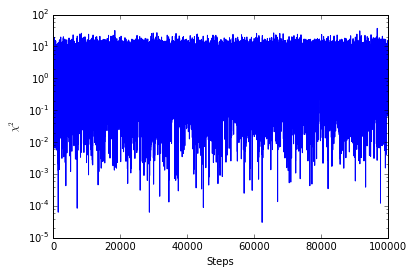

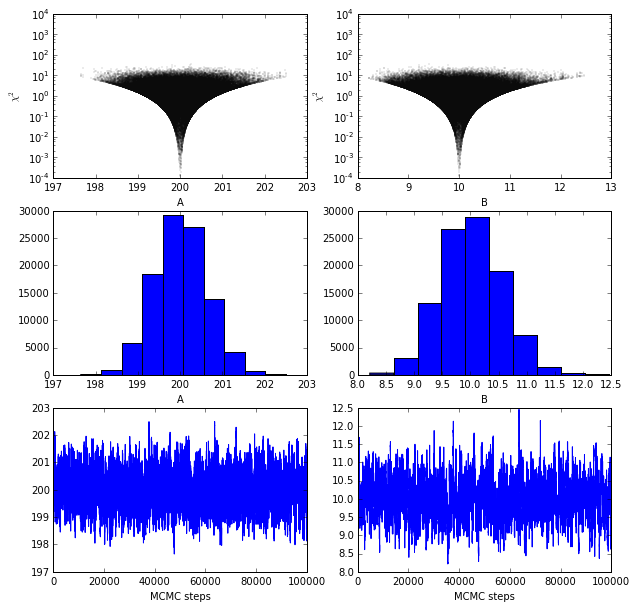

In [8]:
#####################################
#                                   #
#     The Awesome MCMC method       #
#                                   #
#####################################

data = model0(k)

A = 199
B = 10.2

Model = f(k,A,B)
L = likelihood(data,Model)

MCsteps = 100000
MCMC_steps = []

print L[1]
for step in range(MCsteps):
    A_new = np.random.normal(A,0.5)
    B_new = np.random.normal(B,0.1)
    Model_new = f(k,A_new,B_new)
    L_new = likelihood(data,Model_new)
    
    if ( L_new[1]/L[1] <=1 ):
        A = A_new
        B = B_new
        L = L_new
    else:
        p = random.rand(1)[0]
        if ( exp( - L_new[1]+L[1] )> p):
            A = A_new
            B = B_new
            L = L_new

            
    MCMC_steps.append([A,B,L_new[1]])
    if (step%10000==0):
        print step

MCMC_steps = array(MCMC_steps); A_walk = MCMC_steps[:,0]; B_walk = MCMC_steps[:,1]; L_walk = MCMC_steps[:,2]


plot(L_walk); yscale('log'); ylabel(r'$\chi^2$'); xlabel('Steps')

fig = figure(figsize=(10,10)); gs1 = GridSpec(3,2)

ax0 = plt.subplot(gs1[0,0])
ax1 = plt.subplot(gs1[0,1])  
ax2 = plt.subplot(gs1[1,0])  
ax3 = plt.subplot(gs1[1,1])  
ax4 = plt.subplot(gs1[2,0])  
ax5 = plt.subplot(gs1[2,1])  

ax0.scatter(A_walk,L_walk, s=0.01)
ax1.scatter(B_walk,L_walk, s=0.01)
ax2.hist(A_walk)
ax3.hist(B_walk)
ax4.plot(A_walk)
ax5.plot(B_walk)


ax0.set_yscale('log'); ax0.set_ylim([0.0001,10000])
ax1.set_yscale('log'); ax1.set_ylim([0.0001,10000])

ax0.set_xlabel('A')
ax1.set_xlabel('B')
ax2.set_xlabel('A')
ax3.set_xlabel('B')
ax4.set_xlabel('MCMC steps')
ax5.set_xlabel('MCMC steps')

ax0.set_ylabel(r'$\chi^2$')
ax1.set_ylabel(r'$\chi^2$')


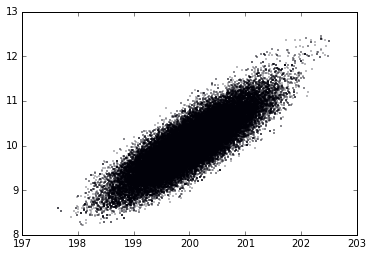

In [9]:
scatter(A_walk,B_walk,s=0.1)

<matplotlib.colorbar.Colorbar instance at 0x108ea47e8>

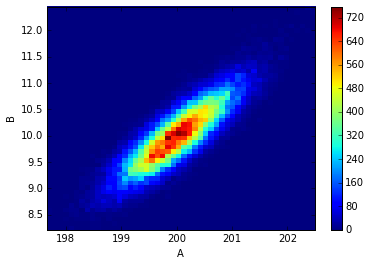

In [10]:
hist2d(A_walk,B_walk,bins=50)
xlabel('A')
ylabel('B')
colorbar()

(100000, 2)


<matplotlib.colorbar.Colorbar instance at 0x1073b91b8>

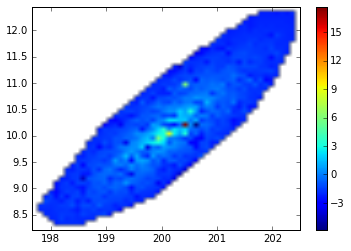

In [17]:
min_B = amin(B_walk)
max_B = amax(B_walk)
min_A = amin(A_walk)
max_A = amax(A_walk)
grid_A, grid_B = mgrid[min_A:max_A:50j, min_B:max_B:50j]

from scipy.interpolate import griddata
n_points = size(A_walk)
points = ones((n_points,2))
print shape(points)
points[:,0] = A_walk
points[:,1] = B_walk
grid_l = griddata(points, -log(L_walk), (grid_A, grid_B), method='cubic')
imshow(grid_l.T, extent=(min_A,max_A,min_B,max_B), aspect='auto',origin='lower')

colorbar()

<matplotlib.colorbar.Colorbar instance at 0x110836320>

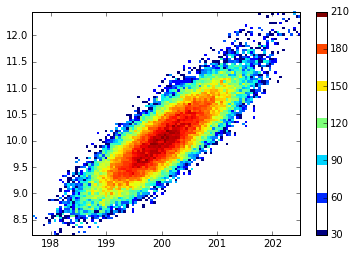

In [12]:
from matplotlib.colors import LogNorm
from matplotlib.pyplot import *

levels = np.arange(0, 300, 5)

counts,ybins,xbins,image = hist2d(A_walk,B_walk,bins=100,norm=LogNorm())
contour(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], linewidths=10)
colorbar()



<matplotlib.colorbar.Colorbar instance at 0x11096c7e8>

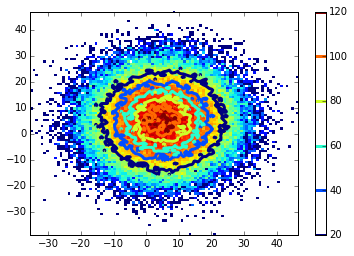

In [13]:
from matplotlib.colors import LogNorm
from matplotlib.pyplot import *

x = np.random.normal(5,10,100000)
y = np.random.normal(5,10,100000)
counts,ybins,xbins,image = hist2d(x,y,bins=100,norm=LogNorm())
contour(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3)
colorbar()